In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5 # increase for more accuracy
BS = 32

DIRECTORY = r"C:\Users\Divyam\Desktop\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)   # we use this because of mobilenet

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


e:\anaconda3\envs\mtcnn\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
labels

['with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with

In [6]:
# perform one-hot encoding on the labels (we cant just use withmask and without mask)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
labels.shape

(3833, 2)

In [8]:
#only with arrays DL works
data = np.array(data, dtype="float32")
labels = np.array(labels)


In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# fully connected layer at top is FALSE
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [13]:
# construct the head of the model that will be placed on top of the
# the base model
# fully connected layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)  # to prevent overfitting
headModel = Dense(2, activation="softmax")(headModel)  #for 2 output (mask / no mask)

In [14]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [17]:
# compile our model

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [18]:
# train the head of the network
print("[INFO] training start...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training start...
Epoch 1/5
95/95 [==============================] - 209s 2s/step - loss: 0.5781 - accuracy: 0.7240 - val_loss: 0.1314 - val_accuracy: 0.9896
Epoch 2/5
95/95 [==============================] - 190s 2s/step - loss: 0.1599 - accuracy: 0.9633 - val_loss: 0.0705 - val_accuracy: 0.9883
Epoch 3/5
95/95 [==============================] - 198s 2s/step - loss: 0.0921 - accuracy: 0.9775 - val_loss: 0.0501 - val_accuracy: 0.9935
Epoch 4/5
95/95 [==============================] - 196s 2s/step - loss: 0.0803 - accuracy: 0.9731 - val_loss: 0.0449 - val_accuracy: 0.9922
Epoch 5/5
95/95 [==============================] - 191s 2s/step - loss: 0.0602 - accuracy: 0.9848 - val_loss: 0.0376 - val_accuracy: 0.9935


In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [20]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [22]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector71.model", save_format="h5")

[INFO] saving mask detector model...


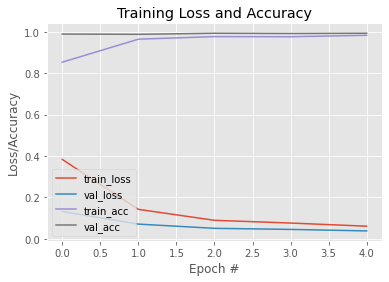

In [23]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot71.png")

In [ ]:
# for detecting it in webcam

In [27]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = r"C:\Users\Divyam\Desktop\Face-Mask-Detection-master\face_detector\deploy.prototxt"
weightsPath = r"C:\Users\Divyam\Desktop\Face-Mask-Detection-master\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model(r"C:\Users\Divyam\Desktop\Face-Mask-Detection-master\mask_detector71.model")

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)


KeyboardInterrupt: 